1. Getting VizDoom Up and Running

In [1]:
#!pip install vizdoom

In [2]:
#!git clone https://github.com/Farama-Foundation/ViZDoom

In [3]:
# Import vizdoom for game env
from vizdoom import *
# Import random for action sampling
import random
# Import time for sleeping
import time
# Import numpy for identity matrix
import numpy as np

In [4]:
# Setup game
game = DoomGame()
game.load_config("github\ViZDoom\scenarios\deadly_corridor.cfg")
game.init()

In [5]:
# This is the set of actions we can take in the environment
actions = np.identity(7,dtype=np.uint8)
actions

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1]], dtype=uint8)

In [6]:
random.choice(actions)

array([0, 1, 0, 0, 0, 0, 0], dtype=uint8)

In [7]:
# Loop through the episodes
episodes = 10
for episode in range(episodes):
    # Create a new episode or game
    game.new_episode()
    # Check the game isn't done
    while not game.is_episode_finished():
        state = game.get_state()
        img = state.screen_buffer
        info = state.game_variables
        reward = game.make_action(random.choice(actions),4)

        print("reward: ", reward )
        time.sleep(0.02)
    print("Result: ", game.get_total_reward())
    time.sleep(2)

game.close()

reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  -15.815628051757812
reward:  0.0
reward:  0.0
reward:  1.6541748046875
reward:  1.9710235595703125
reward:  0.205780029296875
reward:  0.0
reward:  0.0
reward:  -3.991058349609375
reward:  0.0
reward:  -0.000457763671875
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  -100.0
Result:  -115.97616577148438
reward:  0.0
reward:  0.0
reward:  7.110260009765625
reward:  8.529800415039062
reward:  -10.988571166992188
reward:  -2.6819610595703125
reward:  -1.910003662109375
reward:  -0.8946990966796875
reward:  -0.7530975341796875
reward:  -0.7375640869140625
reward:  -7.687347412109375
reward:  -5.900360107421875
reward:  -0.0626983642578125
reward:  -0.0230712890625
reward:  0.0
reward:  6.22247314453125
reward:  5.62994384765625
reward:  -3.5730133056640625
reward:  -5.9355316162109375
reward:  -2.339569091796875
reward:  -100.0
Result:  -115.99501037597656
reward:  0.0
reward:  0.78125
reward:  -4.655715

2. Converting it to a Gym Environment

In [8]:
# Import environment base class form OpenAI Gym
from gym import Env
# Import hym spaces
from gym.spaces import Discrete, Box
# Import opencv
import cv2


In [9]:
Discrete(7).sample()

1

In [10]:
actions[Discrete(7).sample()]

array([0, 0, 1, 0, 0, 0, 0], dtype=uint8)

In [11]:
class VizDoomGym(Env):
    # Function that is called when we start the env
    def __init__(self, render = False):

        super(VizDoomGym, self).__init__()

        # Setup the game
        self.game = DoomGame()
        self.game.load_config("github\ViZDoom\scenarios\deadly_corridor.cfg")
        

        # Render frame logic
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)

        # Start the game
        self.game.init()


        # Create the observation_space and action_space
        self.observation_space = Box(low=0, high=255, shape = (100,160,1), dtype=np.uint8)
        self.action_space = Discrete(7)
    
    # This is how we take a step in the environment
    def step(self, action):

        # Speficy action and take step
        actions = np.identity(7,dtype=np.uint8)
        reward = self.game.make_action(actions[action], 4)
        
        # Get all the other stuff we need to return
        if self.game.get_state():
       
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            ammo = self.game.get_state().game_variables[0]
            info = {"ammo":ammo}
           

        else:

            state = np.zeros(self.observation_space.shape)
            ammo = 0
            info = {"ammo":ammo}

        done = self.game.is_episode_finished()

        return state, reward, done, info
    
    # Define how to render the game or environment
    def render():
        pass

    # What happens when we start a new game
    def reset(self):
        
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)
    
    # Grayscale the game and resize it
    def grayscale(self, observation):
        
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state
        
    
    # Call to close down the game
    def close(self):
        self.game.close()
        


In [12]:
env = VizDoomGym()

In [13]:
state = env.reset()

In [14]:
# Import Environment checker
from stable_baselines3.common import env_checker

C:\Users\hosma\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
env_checker.check_env(env)

In [16]:
env.close()

3. View State

In [17]:
from matplotlib import pyplot as plt

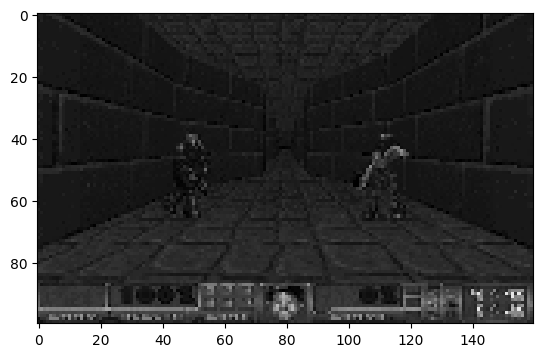

In [18]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

4. Setup Callback

In [19]:
# Import os for file path management
import os
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [20]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path,exist_ok=True)
    
    def _on_step(self) :
        
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path,"best_model_{}".format(self.n_calls))
            self.model.save(model_path)

        return True
        

In [21]:
CHECKPOINT_DIR = "./train/train_deatly_coridor"
LOG_DIR = "./logs/log_deatly_coridor"

In [22]:
# Setup model saving callbacks
callback = TrainAndLoggingCallback(check_freq=10000,save_path=CHECKPOINT_DIR)

5. Train the Model

In [23]:
# Import PPO for training
from stable_baselines3 import PPO

In [24]:
env = VizDoomGym(render = True)


In [25]:
model = PPO("CnnPolicy", env, tensorboard_log = LOG_DIR, verbose = 1, learning_rate = 0.0001, n_steps = 512)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [26]:
# Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=1000000,callback=callback)

Logging to ./logs/log_deatly_coridor\PPO_2


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.9     |
|    ep_rew_mean     | -74      |
| time/              |          |
|    fps             | 18       |
|    iterations      | 1        |
|    time_elapsed    | 28       |
|    total_timesteps | 512      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.6        |
|    ep_rew_mean          | -81.1       |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 2           |
|    time_elapsed         | 50          |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.022765933 |
|    clip_fraction        | 0.346       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.93       |
|    explained_variance   | 0.000194    |
|    learning_rate        | 0.

KeyboardInterrupt: 

In [ ]:
# If you want to see logs
# tensorboard --logdir=. 

6. Test the Model

In [27]:
# Import eval policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy

In [28]:
# Reload model from disc
model = PPO.load("train/train_deatly_coridor/best_model_270000.zip")

In [29]:
env = VizDoomGym(render=True)

In [32]:
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes = 100)

In [33]:
mean_reward

289.0911506652832

In [35]:
for episode in range(5):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.2)
        total_reward += reward
    print("Total Reward for episode {} is {}".format(episode, total_reward))
    time.sleep(2)

Total Reward for episode 0 is 56.04600524902344
Total Reward for episode 1 is 122.67703247070312


ViZDoomUnexpectedExitException: Controlled ViZDoom instance exited unexpectedly.